In [66]:
%matplotlib inline
import baltic as bt
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon ## for polygons
from descartes import PolygonPatch
import seaborn as sns
import re

from matplotlib.collections import PatchCollection ## for polygons too
from matplotlib.colors import LinearSegmentedColormap ## for colour maps
from matplotlib import gridspec ## for composite figures
import matplotlib.patheffects as path_effects ## for elegant text
from IPython.display import HTML

from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import math
import time
import sys
import unicodedata
import pandas as pd
from collections import OrderedDict
import numpy as np

import json ## used for importing JSONs
try:
    from StringIO import StringIO as sio
    from cStringIO import StringIO as csio
except ImportError:
    from io import StringIO as sio
    from io import BytesIO as csio
def product(*args, **kwds):
    pools = map(tuple, args) * kwds.get('repeat', 1)
    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]
    for prod in result:
        yield tuple(prod)
            
def colourDict(data,cmap=mpl.cm.viridis):
    """
    returns a dictionary of unique data_items:colour hex code, normalised
    takes a list of items and a cmap as mpl.cm.name
    """
    cmap=cmap # default viridis
    data_unique=sorted(list(set(data))) # includes nan values as a key. That is desirable sometimes
    norm = mpl.colors.Normalize(vmin=0, vmax=len(data_unique))
    colors = [cmap(norm(value)) for value in range(len(data_unique))]
    return dict(zip(data_unique,colors))

def legend(dictionary,marker='o',markersize=15,labelspacing=1,fontsize=10,ax='',style='italic',loc='best',bbox_to_anchor=(0.5, 0.5),fontname='Arial'): # `'upper left', 'upper right', 'lower left', 'lower right'
    """ Returns a legend object from a dictionary"""
    legend_elements=[]
    for key,value in dictionary.items():
        legend_elements.append(Line2D([0],[0],marker=marker,color=value,label=key,markersize=markersize))
    leg=ax.legend(handles=legend_elements, loc=loc,labelspacing=labelspacing,prop={'size': fontsize,'style':style,'family':fontname},bbox_to_anchor=bbox_to_anchor)
    return leg

In [2]:
# loading the raster
raster=pd.read_csv('./colombia_low_low.asc',skiprows=6,sep=' ',header=None,dtype='float')
# masks the cells with nule data using the value asigned by qgis
rasterplot=raster.mask(np.isclose(raster.values,3.4028234663852885981e+38,rtol=0.00001))
# replacing sea cells with np.nan
raster.replace(0,np.nan,inplace=True)

In [3]:
rasterplot

,0,1,2,3,4,5,6,7,8,9,...,4671,4672,4673,4674,4675,4676,4677,4678,4679,4680
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6475,NaN,943.0,1057.0,1083.0,1107.0,1208.0,1405.0,1552.0,1626.0,1579.0,...,103.0,100.0,103.0,101.0,106.0,96.0,103.0,106.0,96.0,85.0
6476,NaN,873.0,999.0,1172.0,1238.0,1287.0,1403.0,1504.0,1613.0,1804.0,...,103.0,105.0,94.0,98.0,97.0,92.0,91.0,89.0,98.0,96.0
6477,NaN,847.0,1013.0,1109.0,1253.0,1327.0,1486.0,1604.0,1781.0,1785.0,...,98.0,93.0,98.0,103.0,102.0,104.0,99.0,90.0,82.0,101.0
6478,NaN,954.0,1035.0,1103.0,1128.0,1327.0,1482.0,1747.0,1719.0,1762.0,...,99.0,95.0,87.0,97.0,87.0,90.0,99.0,90.0,97.0,97.0


In [4]:
# raster information
nrows=6480
ncols=4680

xmin=-79.000138889000 # 
xmax=-65.9998611112399942

ymin=-5.000245726692
ymax=13.0001388886679976

cellsize=0.002777837132

In [5]:
# loading the polygons to shade countries other than Colombia
json_path='./col_borders4.geojson'
json_map=json.load(open(json_path,'r'))
features=json_map['features']
location_points={} ## location points will be stored here
polygons={} ## polygons will be stored here
locName='LEVEL3_COD' ## key name for each feature
total_area={} # keep track of the area of country polygones, for filtering purposes
for loc in features: ## iterate through features (locations)
    poly = np.asarray(loc['geometry']['coordinates']) ## get coordinates
    location=loc['properties'][locName] ## standardised location name (remove diacritics)
    polygons[location]=[]
    location_points[location]=[]
    total_area[location]=[]
    if loc['geometry']['type']=='MultiPolygon': ## multiple parts detected
        totalarea=0
        for part in np.asarray(poly): ## iterate over each component polygon
            for coords in np.asarray(part): ## iterate over coordinates
                coords=np.array(coords)
                # transforming the coordinates into column and row indices of the raster
                xs=(coords[:,0]-xmin)//cellsize ## longitudes
                ys=(6480-(coords[:,1]-ymin)//cellsize) ## latitudes
                location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    if loc['geometry']['type']=='Polygon': ## location is single part
        for coords in np.asarray(poly): ## iterate over coordinates
            coords=np.array(coords)
            # transforming the coordinates into column and row indices of the raster
            xs=(coords[:,0]-xmin)//cellsize ## longitudes
            ys=(6480-(coords[:,1]-ymin)//cellsize) ## latitudes
            location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    complete_location=[]
    for part in location_points[location]: ## iterate over each component of a location
        complete_location.append(Polygon(part,True)) ## create a polygon for each component of a location
    polygons[location]=complete_location ## assign list of polygons to a location

\Python3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
\Python3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [6]:
# loading data
data=pd.read_csv('./coordinates_of_plants_and_ants.csv',sep=',')
data

,Plant,Ant,Collection,Department,Locality,Latitude,Longitude,Altitude
0,Maieta guianensis,Allomerus,MFT142,Amazonas,Leticia,-4.120267,-69.955150,94
1,Maieta guianensis,Allomerus,MFT143,Amazonas,Leticia,-4.120267,-69.955150,94
2,Maieta guianensis,Allomerus,MFT144,Amazonas,Leticia,-4.120267,-69.955150,94
3,Maieta guianensis,Allomerus,MFT145,Amazonas,Leticia,-4.120267,-69.955150,94
4,Tococa guianensis,Azteca,MFT146,Amazonas,Leticia,-4.120233,-69.955417,102
...,...,...,...,...,...,...,...,...
477,Miconia,Wasmania,MFT370,Valle del Cauca,Buenaventura,3.953600,-76.991900,64
478,Conostegia,NN,MFT371,Valle del Cauca,Buenaventura,3.953600,-76.991900,64
479,Conostegia,Azteca,MFT372,Valle del Cauca,Buenaventura,3.953600,-76.991900,64
480,Conostegia,NN,MFT373,Valle del Cauca,Buenaventura,3.953600,-76.991900,64


In [7]:
# cellsize of the raster
xcell=((xmin-xmax)/ncols)*-1
ycell=(ymax-ymin)/nrows
print(xcell,ycell)

0.002777837132000001 0.0027778371319999995


In [8]:
# transform coordinates into column and row index of the raster
data['longs']=(data['Longitude']-xmin)//cellsize
data['lats']=(6480-(data['Latitude']-ymin)//cellsize)
# filtering out collections of plants from other species that are not included in the analyses
datatococa=data[(data['Plant']=='Tococa guianensis') | (data['Plant']=='Tococa')]
datatococa
# data

,Plant,Ant,Collection,Department,Locality,Latitude,Longitude,Altitude,longs,lats
4,Tococa guianensis,Azteca,MFT146,Amazonas,Leticia,-4.120233,-69.955417,102,3256.0,6164.0
5,Tococa,Azteca,MFT147,Amazonas,Leticia,-4.120033,-69.956267,92,3255.0,6164.0
6,Tococa,Azteca,MFT148,Amazonas,Leticia,-4.120033,-69.956267,92,3255.0,6164.0
8,Tococa guianensis,Azteca,MFT150,Amazonas,Leticia,-4.120167,-69.956450,93,3255.0,6164.0
9,Tococa guianensis,Azteca,MFT151,Amazonas,Leticia,-4.120167,-69.956450,93,3255.0,6164.0
...,...,...,...,...,...,...,...,...,...,...
472,Tococa guianensis,Azteca,MFT365,Valle del Cauca,Buenaventura,3.953600,-76.991900,64,722.0,3257.0
473,Tococa guianensis,Azteca,MFT366,Valle del Cauca,Buenaventura,3.953600,-76.991900,64,722.0,3257.0
474,Tococa guianensis,Azteca,MFT367,Valle del Cauca,Buenaventura,3.953600,-76.991900,64,722.0,3257.0
475,Tococa guianensis,Azteca,MFT368,Valle del Cauca,Buenaventura,3.953600,-76.991900,64,722.0,3257.0


In [9]:
clist=[(0.0,'#737373'),
       (1.0,'#ffffff')]

cmap=mpl.colors.LinearSegmentedColormap.from_list('mycmap',clist)

In [58]:
# setting lists and dictionaries:
# all locations ordered southwards and eastwards
locations=['Barrancabermeja','Cimitarra','Arusi','Buenaventura','San Carlos','San Luis','Amalfi','Tauramena','Villanueva','Villavicencio','Acacías','S.J. de Arama','Villagarzon','Leticia']
# to add a space between locations within a single area (for the ancestral area reconstruction)
change_areas=['Leticia','Villagarzon','Villavicencio','Tauramena','San Carlos','Buenaventura','Arusi']
# dictionary of areas:colour for the ancestral area reconstructions
area_dict_col={'Santander':'#deebf7','Choco':'#08519c','Valle del Cauca':'#4292c6','Antioquia':'#9ecae1','Casanare':'#fed976','Meta':'#fd8d3c','Putumayo':'#e31a1c','Amazonas':'#800026'}
area_dict={'Barrancabermeja':'Santander','Cimitarra':'Santander','Arusi':'Choco','Buenaventura':'Valle del Cauca','San Carlos':'Antioquia','San Luis':'Antioquia','Amalfi':'Antioquia',
          'Tauramena':'Casanare','Villanueva':'Casanare','Villavicencio':'Meta','Acacías':'Meta','S.J. de Arama':'Meta','Villagarzon':'Putumayo','Leticia':'Amazonas'}
# adding numbers
loc_tuples=[(index+1,loc) for index,loc in enumerate(locations)]
# dictionary ant genera:colour
ant_dict=colourDict(sorted(datatococa['Ant'].unique(), key=str.lower, reverse=False),cmap=mpl.cm.tab20b)
# dictionary location:location number
loc_num_dict=dict(zip([x[1] for x in loc_tuples],[x[0] for x in loc_tuples]))

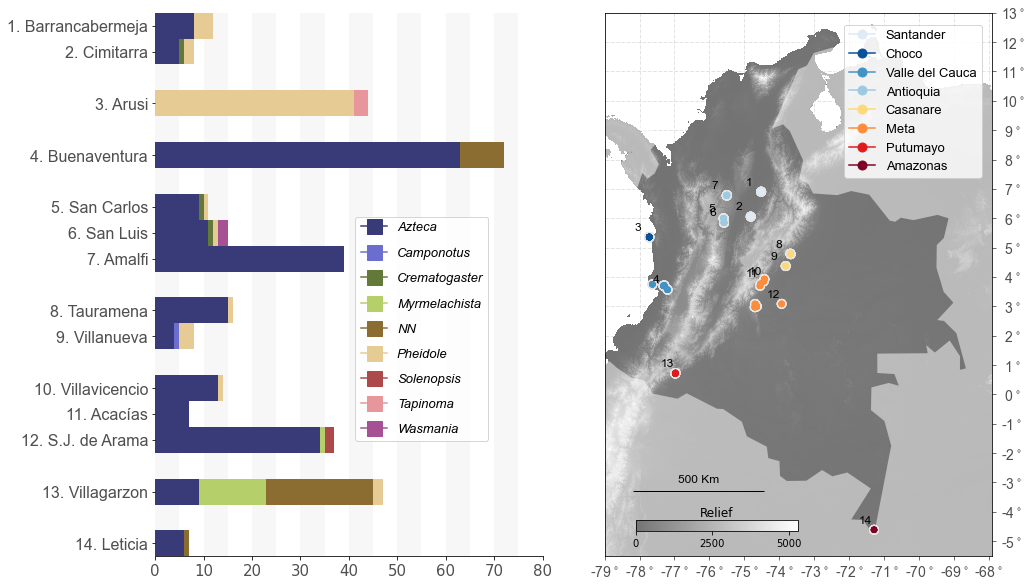

In [75]:
fig = plt.figure(figsize=(15,10),facecolor='w') 
G = gridspec.GridSpec(1,2,wspace=0.16,hspace=0.0)
ax1=plt.subplot(G[0,0],facecolor='none')

# plotting the horizontal bars (number of samples per ant genera per location)
plt.ylim(-0.5,20.5);plt.xlim(0,80)
for x in range(0,82,10):
    ax1.axvspan(xmin=x,xmax=x+5,ymin=ax1.get_ylim()[0],ymax=ax1.get_ylim()[1],facecolor="#bababa",alpha=0.1,zorder=1)
y=0 ; yticks=[]
height=1
for loc in locations[::-1]: # iterate through locations ordered geographically
    temp=datatococa[datatococa['Locality']==loc].groupby(by='Ant')['Collection'].count().reset_index() # columns: Ant  Collection
    yticks.append(y)
    left=0
    for spp in temp['Ant'].unique(): # iterate through ant species
        width=temp[temp['Ant']==spp]['Collection'].values
        ax1.barh(y=y,width=width,height=height,left=left,color=ant_dict[spp],alpha=1)
        left+=width
    y+=2 if loc in change_areas else 1
legend(ant_dict,marker='s',fontsize=13,ax=ax1,loc='lower left',bbox_to_anchor=(0.5, 0.2)) # (x, y, width, height)
[ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]
plt.yticks(ticks=yticks,labels=['%s. %s'%(i[0],i[1]) for i in loc_tuples[::-1]],fontsize=16,fontname='Arial',color='#4f4f4f')
plt.xticks(color='#4f4f4f',fontsize=15)

# plotting the map
ax2=plt.subplot(G[0,1])
plt.xlim(0,ncols); plt.ylim(0,nrows)
# add grid behind
for y in range(0,6500,350):
    ax2.hlines(y=y,xmin=0,xmax=ncols,lw=1,ls='--',color='#bababa',zorder=1,alpha=0.4)
    
for x in range(int(ax2.get_xlim()[0]),int(ax2.get_xlim()[1]),422):
    ax2.vlines(x=x,ymin=0,ymax=int(ax2.get_xlim()[1]),lw=1,ls='--',color='#bababa',zorder=1,alpha=0.4)

vmin=1; vmax=5300
# lazy plotting the tiff
sns.heatmap(rasterplot,cmap=cmap,cbar=False,vmin=vmin,vmax=vmax,alpha=1,zorder=2,ax=ax2,xticklabels=False,yticklabels=False)

# plotting polygons to shade countries other than Colombia
for loc in polygons.keys():
    ax2.add_collection(PatchCollection(polygons[loc],facecolor='w',edgecolor='w',alpha=0.5,linewidth=0.1,zorder=2))
ax2.plot()
[ax2.spines[loc].set_visible(True) for loc in ['top','right','left','bottom']]
for loc in ax2.spines:
    sp=ax2.spines[loc]
    sp.set_zorder(6)

# adding the degrees on each axis
plt.xticks(labels=['%2.f$^\circ$'%(x) for x in range(-79,-67,1)],ticks=[x for x in range(int(ax2.get_xlim()[0]),int(ax2.get_xlim()[1]),422)],fontname='Arial',fontsize=14)
ax2.set_yticks(ticks=[y for y in range(0,6500,350)]) #,labels=['%2.f'%(y) for y in range(-5,13,1)],fontname='Arial',fontsize=15)
ax2.set_yticklabels(labels=['%2.f$^\circ$'%(y) for y in range(-5,14,1)][::-1],fontname='Arial',fontsize=14)
plt.tick_params(axis='both', which='major', pad=5,labelcolor='#4f4f4f',color='#4f4f4f')
ax2.yaxis.tick_right()

# plotting the collecting locations and their numbers
ax2.scatter(datatococa['longs'],datatococa['lats'],s=42,zorder=4,facecolor=datatococa['Locality'].map(area_dict).map(area_dict_col),edgecolor='none')
ax2.scatter(datatococa['longs'],datatococa['lats'],s=100,zorder=3,facecolor='#e6e6e6',alpha=1,edgecolor='none') # bacground
for row in datatococa.groupby(by=['Locality']).first().reset_index().itertuples(): # plot the population numbers using the first coordinate in the table
    ax2.text(x=row.longs-180,y=row.lats-80,s='%s'%(loc_num_dict[row.Locality]),fontname='Arial',fontsize=12,zorder=5)

# legend
legend(area_dict_col,marker='o',fontsize=13,ax=ax2,loc='upper right',style='normal',bbox_to_anchor=(0.99,0.99),markersize=9,labelspacing=0.5) # (x, y, width, height)

# adding distance scale
ax2.hlines(y=5700,xmin=345,xmax=345+(350*4.5),lw=1,ls='-',zorder=3)
ax2.text(x=(345+345+(350*4.5))/2,y=5600,s='500 Km',fontsize=12,fontname='Arial',ha='center',zorder=3)

# adding colorbar
axcb=fig.add_axes([0.57,0.16, 0.15, 0.015], frame_on=False) # left(leftx) | bottom | width | height
cb=mpl.colorbar.ColorbarBase(axcb,cmap=cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),orientation='horizontal',alpha=1.0,drawedges=False)#
axcb.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2500))
axcb.set_xlim(0,5300)
axcb.xaxis.set_label_position('top')
axcb.set_xlabel('Relief',size=12)

# plt.savefig('./Fig1_map_antcollections.pdf',bpi=300)
plt.show()